# 2. PyTorch dataset and data loader

In the previous notebook, we have learned how to investigate our dataset. Next up, we'll want to create a PyTorch `Dataset` and a PyTorch `DataLoader`. These will help us get our data ready to be passed through a neural network.

## 2.1 Creating a PyTorch dataset

A [PyTorch `Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is an abstract representation of a dataset. You can do two things with a PyTorch `Dataset`: get the *item* at a certain **index**, and get the **length** of the dataset (i.e., the number of *items*). That's all. What an *item* is, is entirely up to you, but in the case of classification, it is typically a tuple of an image and a class label.

### 2.1.1 Built-in datasets

Torchvision already includes [many datasets](https://pytorch.org/vision/stable/datasets.html) to play around with. Let's take a look at the [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) dataset.

In [2]:
from torchvision.datasets import MNIST

mnist_dataset = MNIST("../data/", train=True, download=True)

12.9%

100.0%


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



100.0%

Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw




77.5%

100.0%


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



100.0%

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



We can ask an item at a certain index:

In [3]:
mnist_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

This gives us two things: an image and an integer label.

In [4]:
img, label = mnist_dataset[100]

In [5]:
img

In [6]:
label

5

We can also ask the length of the dataset.

In [7]:
len(mnist_dataset)

60000

### 2.1.2 A first attempt to a custom dataset

To implement your own dataset, you need create a class that inherits from [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and implements two methods: `__getitem__()` and `__len__()`.

For our Pokémon use case:

- `__getitem__()` should return the image at the given index, along with the name of that Pokémon;
- `__len__()` should return the number of images.

In the previous notebook, we saw how we can represent our dataset as a Pandas `DataFrame`. We can use this representation to implement `__getitem__()` and `__len__()` without much new code:

In [8]:
from torch.utils.data import Dataset
import pandas as pd
from pathlib import Path
from PIL import Image


class SignDataset(Dataset):
    def __init__(self, path, transform=None):
        dataPath = Path(path)
        self.transform = transform
        self.df = pd.DataFrame([{'label': file.parent.name, 'image': file} for file in dataPath.glob('*/*')])

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img = Image.open(row['image'])
       
        if self.transform is not None:
            img = self.transform(img)
        
        label = row['label']

        return img, label 
    
    def __len__(self):
        return len(self.df)

In [9]:
dataset = signDataset('./data/classification')

We can play around with this dataset, just like with the MNIST dataset.

In [10]:
img, label = dataset[100]
img

IndexError: single positional indexer is out-of-bounds

In [ ]:
label

'A17'

In [ ]:
len(mnist_dataset)

60000

While this is already a perfectly valid PyTorch `Dataset`, there are two issues:

1. Our labels are strings;
2. We don't make a distinction between train, validation and test data.

> 🤔 **Why is it a problem that our labels are strings?**
>
> When training a network, we typically iterate over *batches* of data. These batches are represented as PyTorch tensors. And it is not possible (and not necessary, really) to create a tensor of strings.

We'll solve both issues in the following sections.

### 2.1.3 Replacing string labels with integer labels

First, we'll replace our string labels by integer labels. For this, we'll create a dictionary that maps each string label to a unique integer.

In [ ]:
dataPath = Path('../data/classification')
df = pd.DataFrame([{'label': file.parent.name, 'image': file} for file in dataPath.glob('*/*')])

To get a list of unique labels, we can call [`unique()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html) on the `label` column:

In [ ]:
df['label'].unique()

array(['A1', 'A17', 'A2', 'A21', 'A30', 'A7', 'B1', 'B2', 'B20', 'B21',
       'B22', 'B23', 'B33', 'B36', 'B41', 'C12', 'C2', 'C4', 'D1', 'D6',
       'other'], dtype=object)

To ensure a consistent mapping across different systems, we can sort these labels with [the built-in Python function `sorted()`](https://docs.python.org/3/library/functions.html#sorted):

In [ ]:
sorted(df['label'].unique())

['A1',
 'A17',
 'A2',
 'A21',
 'A30',
 'A7',
 'B1',
 'B2',
 'B20',
 'B21',
 'B22',
 'B23',
 'B33',
 'B36',
 'B41',
 'C12',
 'C2',
 'C4',
 'D1',
 'D6',
 'other']

Now, with [the built-in Python function `enumerate()`](https://docs.python.org/3/library/functions.html#enumerate), we can get an iterable that yields another integer value for each of our labels.

In [11]:
for i, label in enumerate(sorted(df['label'].unique())):
    print(i, label)

NameError: name 'df' is not defined

So, we can create our label-to-integer dictionary with the following `for` loop:

In [12]:
dictionarry = {}

for integer, label in enumerate(sorted(df['label'].unique())):
    dictionarry[label] = integer

dictionarry

NameError: name 'df' is not defined

Or, we can use a [dictionary comprehension](https://www.geeksforgeeks.org/python-dictionary-comprehension/):

In [13]:
dictionarry = {label : integer for integer, label in enumerate(sorted(df['label'].unique()))}
dictionarry

NameError: name 'df' is not defined

We can plug this into our PokemonDataset:

In [18]:
class SignDataset(Dataset):
    def __init__(self, path, transform=None):
        dataPath = Path(path)
        self.transform = transform
        self.df = pd.DataFrame([{'label': file.parent.name, 'image': file} for file in dataPath.glob('*/*')])

        self.label_to_int =  {label : integer for integer, label in enumerate(sorted(df['label'].unique()))}

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img = Image.open(row['image']).convert('RGB')
       
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.label_to_int[row['label']]

        return img, label 
    
    def __len__(self):
        return len(self.df)

Let's try out our new dataset.

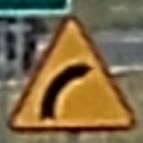

In [19]:
dataset = SignDataset('./data/classification')
img, label = dataset[0]
img

In [20]:
label

0

### 2.1.4 Splitting the data into a train, validation and test split

Training a neural network and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would achieve a perfect score but would fail to predict anything useful on data that was not used during training. This situation is called **overfitting**. To get a better sense of model performance on *unseen* data, it is customary to randomly split the dataset into three disjoint subsets.

1. **Training set**: You train the model with the training set.
2. **Validation set**: Every X training iterations, you evaluate the model performance on the validation set. It is common to only keep the model that obtained the best validation score during training. When training multiple models with different configurations (or *hyperparameters*), you should use the evaluation on the validation set to decide which model to keep.
3. **Test set**: *Once you have decided a model based on validation perfomance*, you evaluate on the test set to get an estimate of the model's ability to generalize to unseen data. In many machine learning competitions, to avoid cheating, the test set is either unlabeled or unavailable to the participants.

As you see, the validation set is used to compare different model configurations, or *hyperparameters*. This could simply be the number of iterations used to train the model, but this also includes the choice of data augmentations, optimizer, learning rate, model architecture (number of layers, number of neurons in a layer, kind of layer,...) etc.

To split our dataset into these subsets, we can use [`sklearn.model_selection.train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split).

In [21]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
train, validate = train_test_split(train, test_size=0.2, random_state=42)

We can update our `PokemonDataset` so that, depending on a given constructor argument, the correct subset is used.

In [53]:
class SignDataset(Dataset):
    def __init__(self, path, subset, transform=None):
        dataPath = Path(path)
        self.transform = transform
        self.df = pd.DataFrame([{'label': file.parent.name, 'image': file} for file in dataPath.glob('*/*')])

        self.label_to_int =  {label : integer for integer, label in enumerate(sorted(df['label'].unique()))}

        train, self.test = train_test_split(self.df, test_size=0.2, random_state=42)
        self.train, self.validate = train_test_split(train, test_size=0.2, random_state=42)

        if subset == 'train':
            self.df = self.train.reset_index(drop=True)
        elif subset == 'val':
            self.df = self.validate.reset_index(drop=True)
        elif subset == 'test':
            self.df = self.test.reset_index(drop=True)
        else:
            raise ValueError(f'Unknown subset "{subset}"')        
        
    def __getitem__(self, index):
        row = self.df.iloc[index]
        img = Image.open(row['image']).convert('RGB')
       
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.label_to_int[row['label']]

        return (img, label)
    
    def __len__(self):
        return len(self.df)

Let's try it out...

In [54]:

print("val\n", SignDataset('./data/classification', subset='val').df)
print("test\n", SignDataset('./data/classification', subset='test').df)
print("train\n", SignDataset('./data/classification', subset='train').df)

val
      label                              image
0       D1     data\classification\D1\122.jpg
1       D1      data\classification\D1\95.jpg
2       D6      data\classification\D6\54.jpg
3    other  data\classification\other\448.jpg
4       D1      data\classification\D1\44.jpg
..     ...                                ...
508     C2      data\classification\C2\24.jpg
509     D6      data\classification\D6\77.jpg
510    A30     data\classification\A30\20.jpg
511  other  data\classification\other\187.jpg
512     B2      data\classification\B2\15.jpg

[513 rows x 2 columns]
test
      label                              image
0       B1      data\classification\B1\33.jpg
1    other  data\classification\other\679.jpg
2    other  data\classification\other\167.jpg
3      C12     data\classification\C12\65.jpg
4    other   data\classification\other\53.jpg
..     ...                                ...
636     D6     data\classification\D6\160.jpg
637    B22     data\classification\B22\19.jpg

### 2.1.5 Cross-validation

Choosing the model that achieved the best performance on the validation set (instead of the training set) avoids selecting a model that has overfit. However, when comparing many models based on validation score, we might select a model that only worked best for the particular random choice of training and validation data. To make a better-informed decision, we can use **cross-validation** techniques.

A basic cross-validation technique is **$k$-fold cross-validation**. Here, the data set is first split up into only two subsets: a *training* set and a *test* set. The training set is partitioned into **$k$ equally-sized folds**. When training a model, we choose one fold for *validation* and the other $k - 1$ folds for *training*. By training a certain model configuration with all $k$ different choices for training and validation and averaging the validation scores, we can effectively select the best model configuration in a more reliable and robust manner. The figure below illustrates the process of $k$-fold cross-validation ([source](https://scikit-learn.org/stable/modules/cross_validation.html)).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" style="max-width: 500px; margin: auto; padding: 2em;"/>

To add support for $k$-fold cross validation to our `PokemonDataset`, we'll first use `train_test_split()` to split our dataset into train+val and test set. Then, with [`numpy.array_split()`](https://numpy.org/doc/stable/reference/generated/numpy.array_split.html), we can split the train+val set into $k$ folds.

In [1]:
import numpy as np

# Define k (the number of folds)
k = 5

# Split dataset into train+val and test
df_trainval, df_test = train_test_split(df, train_size=0.8, random_state=42)

# Split the train+val into k folds
folds = np.array_split(df_trainval, k)

NameError: name 'train_test_split' is not defined

Now, we can choose which fold to use for validation. The other folds should be concatenated to create the training set.

In [ ]:
# ... WRITE YOUR CODE HERE ... #

Plugging this into our `PokemonDataset`:

In [ ]:
# ... WRITE YOUR CODE HERE ... #

Now we can create a training set, validation set and test set:

In [60]:
import torch
from torchvision.transforms import v2

# Create transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.RandomRotation(30),
    v2.RandomResizedCrop(224, antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tfms = v2.Compose([
    v2.ToImage(),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SignDataset('./data/classification', subset='train', transform=train_tfms)
val_dataset = SignDataset('./data/classification', subset='val', )
test_dataset = SignDataset('./data/classification', subset='test')

print(train_dataset[0])

(Image([[[-2.1179, -2.1179, -2.1179,  ..., -1.6042, -1.5699, -1.5699],
        [-2.1179, -2.1179, -2.1179,  ..., -1.6042, -1.5699, -1.5699],
        [-2.1179, -2.1179, -2.1179,  ..., -1.7583, -1.7240, -1.7240],
        ...,
        [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

       [[-2.0357, -2.0357, -2.0357,  ..., -0.3025, -0.2675, -0.2675],
        [-2.0357, -2.0357, -2.0357,  ..., -0.3025, -0.2675, -0.2675],
        [-2.0357, -2.0357, -2.0357,  ..., -0.4426, -0.4251, -0.4251],
        ...,
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

       [[-1.8044, -1.8044, -1.8044,  ...,  1.1411,  1.1585,  1.1585],
        [-1.8044, -1.8044, -1.8044,  ...,  1.1411,  1.1585,

> ⚠️ **Don't use random transforms for validation or test set!**
>
> To avoid making the validation and test evaluations irreproducible, you should not use randomness in the transforms that you'll use for the validation and test set.

Hooray! 🙌 We now have a full-fledged PyTorch `Dataset` with support for $k$-fold cross-validation! 🎉

## 2.2 PyTorch data loader

A PyTorch `Dataset` allows us to easily get images (and labels) from our dataset. When training a neural network, however, we can save training time by training with **batches** of data, instead of passing the images through the network one-by-one.

Batching your data is the task of the [PyTorch `DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). Given a PyTorch `Dataset` that returns a tuple with an image tensor and an integer label, it is very simple to create a `DataLoader`:

In [65]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset, batch_size=10)

A `DataLoader` is an iterable, where each iteration item is a batch of data samples. As with any iterable in Python, you can iterate over a `DataLoader` using a `for` loop. Let's inspect what's inside an iteration item.

In [64]:
for batch in dataloader:
    pass
batch

[tensor([[[[ 1.7009,  1.7009,  1.6838,  ..., -0.6109, -0.5767, -0.5596],
           [ 1.7009,  1.7009,  1.6838,  ..., -0.6281, -0.5938, -0.5767],
           [ 1.7009,  1.7009,  1.7009,  ..., -0.6794, -0.6281, -0.6109],
           ...,
           [ 0.7077,  0.7077,  0.7077,  ..., -2.1179, -2.1179, -2.1179],
           [ 0.7248,  0.7248,  0.7248,  ..., -2.1179, -2.1179, -2.1179],
           [ 0.7248,  0.7248,  0.7248,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[ 2.0959,  2.0959,  2.1134,  ..., -0.4601, -0.4251, -0.4076],
           [ 2.0959,  2.0959,  2.1134,  ..., -0.4776, -0.4426, -0.4251],
           [ 2.0959,  2.0959,  2.0959,  ..., -0.5301, -0.4776, -0.4601],
           ...,
           [-0.7227, -0.7227, -0.7227,  ..., -2.0357, -2.0357, -2.0357],
           [-0.6877, -0.6877, -0.6877,  ..., -2.0357, -2.0357, -2.0357],
           [-0.6877, -0.6877, -0.6877,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[ 2.4483,  2.4483,  2.4483,  ..., -0.2532, -0.2184, -0.2010],
           [ 

Our `DataLoader` composes the first batch with the samples at index $0,\ldots, 9$, the second batch $10,\ldots,19$ and so on. To compose the batches with random samples, you can pass `shuffle=True` to the `DataLoader` constructor.

> ⚠️ **Only shuffle the training set!**
>
> It is considered bad practice to shuffle any of your evaluation sets, as this might make your evaluations irreproducible.

In [66]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

When taking a look at the implementation of `__getitem__()` in our `PokemonDataset`, you'll see that it involves loading an image from disk with `read_image()` and applying image transforms. Both of these steps may block the computing process for a while. If we'd sequentially run `__getitem__()` for the 10 indices in our batch, it might take some time before the batch is created. Setting the argument `num_workers` as a positive integer will turn on **multi-process data loading** with the specified number of loader worker processes.

In [67]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=10)

In summary, the following code creates our train, validation and test datasets and data loaders.

In [68]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=10)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=10)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=10)

And with this, we have covered everything on the data side! 💪 Our data is now ready to be passed into a neural network!

In [ ]:
# ... WRITE YOUR CODE HERE ... #